<a href="https://colab.research.google.com/github/pablo-arantes/EGB2025-MC14/blob/main/GFN2_xTB_PLACER_AEV_PLIG_EGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hi there!**

This is a Jupyter notebook for running molecular docking calculations with Uni-Dock, a GPU-accelerated molecular docking program.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to perform drug binding structure prediction in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for docking calculations and MD simulations!** It is just simple docking pipeline illustrating each step of a docking and MD protocol.

---


**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Cloud-Bind/issues

**Acknowledgments**
- We would like to thank the [Uni-Dock](https://github.com/dptech-corp/Uni-Dock) team for doing an excellent job open sourcing the software.
- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).
- We would like to thank [@ruiz_moreno_aj](https://twitter.com/ruiz_moreno_aj) for his work on [Jupyter Dock](https://github.com/AngelRuizMoreno/Jupyter_Dock)
- We would like to thank the ChemosimLab ([@ChemosimLab](https://twitter.com/ChemosimLab)) team for their incredible [ProLIF](https://prolif.readthedocs.io/en/latest/index.html#) (Protein-Ligand Interaction Fingerprints) tool.
- We would like to thank the [OpenBPMD](https://github.com/Gervasiolab/OpenBPMD) team for their open source implementation of binding pose metadynamics (BPMD).
- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.
- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.
- A Cloud-Bind by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
import tarfile
import os

import subprocess
import sys

commands = [
    "pip -q install py3Dmol",
    "pip install git+https://github.com/pablo-arantes/biopandas",
    "pip install bio",
    "pip install torchani",
    "pip install ase",
    "mamba install -c conda-forge pdbfixer -y",
    "mamba install -c conda-forge openbabel -y",
    "mamba install -c conda-forge parmed -y",
    "mamba install -c conda-forge openmmforcefields -y",
    "wget https://github.com/dptech-corp/Uni-Dock/releases/download/1.1.0/unidock-1.1.0-cuda120-linux-x86_64",
    "mv unidock-1.1.0-cuda120-linux-x86_64 unidock",
    "chmod +x unidock",
    "wget https://github.com/gnina/gnina/releases/download/v1.3/gnina",
    "chmod +x gnina",
    "wget https://github.com/rdk/p2rank/releases/download/2.4/p2rank_2.4.tar.gz",
    "pip install qcelemental",
    "pip install torch_geometric",
    "pip install scikit-learn",
    "git clone https://github.com/pablo-arantes/AEV-PLIG.git",
    "mamba install -c conda-forge pymol-open-source -y",
    "pip install xtb",
    "pip install logmd==0.1.30",
    "pip install MDAnalysis",
    "pip install posebusters --upgrade"
]


for cmd in commands:
    subprocess.run(cmd, shell=True)

file = tarfile.open('p2rank_2.4.tar.gz')
file.extractall('/content/')
file.close()
os.remove('p2rank_2.4.tar.gz')


#load dependencies
import parmed as pmd
from biopandas.pdb import PandasPdb
import urllib.request
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as statsz
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors

In [ ]:
#@title **Install PLACER dependencies**
#@markdown Please, continue drinking your coffee and wait. ;-)

#@markdown Protein-Ligand Atomistic Conformational Ensemble Resolver (PLACER) is a graph neural network that operates entirely at the atomic level; the nodes of the graph are the atoms in the system. PLACER was trained to recapitulate the correct atom positions from partially corrupted input structures from the Cambridge Structural Database and the Protein Data Bank. PLACER accurately generates structures of diverse organic small molecules given knowledge of their atom composition and bonding, and given a description of the larger protein context, can accurately build up structures of small molecules and protein side chains; used in this way PLACER has competitive performance on protein-small molecule docking given approximate knowledge of the binding site. PLACER is a rapid and stochastic denoising network, which enables generation of ensembles of solutions to model conformational heterogeneity.

#@markdown Reference: https://www.biorxiv.org/content/10.1101/2024.09.25.614868v1



#install dependencies
%%capture
import sys
import tarfile
import os
import subprocess
import sys

commands = [
    "git clone https://github.com/pablo-arantes/PLACER.git",
    "mamba env create -f /content/PLACER/envs/placer_env_lite.yml"
]


for cmd in commands:
    subprocess.run(cmd, shell=True)

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed.

**Important**: Make sure the PDB file points to the correct structure.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_ligand and so on.**

In [ ]:
#@title **Please, provide the necessary input files below for receptor**:
#@markdown **Important:** Run the cell to prepare your receptor and select your reference residue for the construction of an optimal box size for the docking calculations.
from openmm.app.pdbfile import PDBFile

import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer
from openbabel import pybel

Google_Drive_Path = '/content/3HTB' #@param {type:"string"}
workDir = Google_Drive_Path

workDir2 = os.path.join(workDir)
workDir_check = os.path.exists(workDir2)
if workDir_check == False:
  os.mkdir(workDir2)
else:
  pass

if os.path.exists(os.path.join(workDir, "name_residues.txt")):
  os.remove(os.path.join(workDir, "name_residues.txt"))
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

temp = os.path.join(workDir, "temp.pdb")
receptor = os.path.join(workDir, "receptor.pdb")
receptor_pdbqt = os.path.join(workDir, "receptor.pdbqt")
ligand = os.path.join(workDir, "ligand.pdbqt")


Query_PDB_ID = '3HTB' #@param {type:"string"}

pdbfn = Query_PDB_ID + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm = os.path.join(workDir, pdbfn)
urllib.request.urlretrieve(url, outfnm)


ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.to_pdb(path=temp, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#prepare receptor
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))

path = '/content/'


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues.txt"), "a",))
          i += 1

extract_ligands(path)

def extract_ligands2(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands2(path)

# mol= [m for m in pybel.readfile(filename=receptor, format='pdb')][0]
# out=pybel.Outputfile(filename=receptor_pdbqt,format='pdbqt',overwrite=True)
# pybel.Molecule()
# out.write(mol)
# out.close()

os.system("obabel -i pdb " + str(receptor) + " -o pdbqt -O " + str(receptor_pdbqt) + " -xr --partialcharge")

dataset = pd.read_csv(os.path.join(workDir, 'name_residues.txt'), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

b = 1
res_number = []
for j in new2:
  res_number.append(b)
  b += 1

print("Residue" + " - "  + "Number" )
a = 1
for j in new:
  print(', '.join(j) + " - "  + str(a))
  a += 1

Residue - Number
MET - 1
ASN - 2
ILE - 3
PHE - 4
GLU - 5
MET - 6
LEU - 7
ARG - 8
ILE - 9
ASP - 10
GLU - 11
GLY - 12
LEU - 13
ARG - 14
LEU - 15
LYS - 16
ILE - 17
TYR - 18
LYS - 19
ASP - 20
THR - 21
GLU - 22
GLY - 23
TYR - 24
TYR - 25
THR - 26
ILE - 27
GLY - 28
ILE - 29
GLY - 30
HIS - 31
LEU - 32
LEU - 33
THR - 34
LYS - 35
SER - 36
PRO - 37
ASP - 38
LEU - 39
ASN - 40
ALA - 41
ALA - 42
LYS - 43
SER - 44
GLU - 45
LEU - 46
ASP - 47
LYS - 48
ALA - 49
ILE - 50
GLY - 51
ARG - 52
ASN - 53
CYS - 54
ASN - 55
GLY - 56
VAL - 57
ILE - 58
THR - 59
LYS - 60
ASP - 61
GLU - 62
ALA - 63
GLU - 64
LYS - 65
LEU - 66
PHE - 67
ASN - 68
GLN - 69
ASP - 70
VAL - 71
ASP - 72
ALA - 73
ALA - 74
VAL - 75
ARG - 76
GLY - 77
ILE - 78
LEU - 79
ARG - 80
ASN - 81
ALA - 82
LYS - 83
LEU - 84
LYS - 85
PRO - 86
VAL - 87
TYR - 88
ASP - 89
SER - 90
LEU - 91
ASP - 92
ALA - 93
VAL - 94
ARG - 95
ARG - 96
CYS - 97
ALA - 98
ALA - 99
ILE - 100
ASN - 101
GLN - 102
VAL - 103
PHE - 104
GLN - 105
MET - 106
GLY - 107
GLU - 108
THR - 109
G

In [ ]:
#@title **Predict ligand-binding pockets from your protein structure using P2Rank**:
#@markdown **P2Rank** is a stand-alone command line program that predicts ligand-binding pockets from a protein structure. It achieves high prediction success rates without relying on an external software for computation of complex features or on a database of known protein-ligand templates.
#@markdown P2Rank makes predictions by scoring and clustering points on the protein's solvent accessible surface. Ligandability score of individual points is determined by a machine learning based model trained on the dataset of known protein-ligand complexes. For more details see [here](https://github.com/rdk/p2rank).

import subprocess
import csv

output_p2rank = os.path.join(workDir, "output_p2rank")
p2rank = "/content/p2rank_2.4/prank predict -f " + str(receptor) + " -o " + str(output_p2rank)
original_stdout = sys.stdout
with open('p2rank.sh', 'w') as f:
  sys.stdout = f
  print(p2rank)
  sys.stdout = original_stdout
subprocess.run(["chmod 700 p2rank.sh"], shell=True)
subprocess.run(["./p2rank.sh"], shell=True,)

with open(os.path.join(workDir, "output_p2rank/receptor.pdb_predictions.csv"), 'r') as file:
  csvreader = csv.reader(file)
  residue = []
  score = []
  center_x = []
  center_y = []
  center_z = []
  for row in csvreader:
    residue.append(row[9:10])
    score.append(row[2:3])
    center_x.append(row[6:7])
    center_y.append(row[7:8])
    center_z.append(row[8:9])

for i in range(1,len(residue)):
  file = str((residue[i])[0]).split()
  score_end = str((score[i])[0]).split()
  center_x_end = str((center_x[i])[0]).split()
  center_y_end = str((center_y[i])[0]).split()
  center_z_end = str((center_z[i])[0]).split()
  print("Pocket " + str(i))
  print("Score = " + score_end[0])
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  print("Selected Residues = " + str(final_residues))
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")

Pocket 1
Score = 13.61
Selected Residues = [10, 103, 104, 105, 106, 107, 108, 11, 137, 138, 141, 142, 145, 18, 20, 21, 22, 24, 26, 30, 31, 32, 35, 70, 73, 74, 77]
Center x = 26.9061 Center y = -13.2369 Center z = -10.2065

Pocket 2
Score = 3.53
Selected Residues = [102, 103, 111, 118, 121, 153, 78, 84, 87, 88, 91, 99]
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Pocket 3
Score = 2.13
Selected Residues = [100, 3, 71, 75, 88, 96, 97]
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428



In [ ]:
#@title **Please, provide the pocket or residue number for the selection**:
#@markdown **Important:** The selected pocket or residues will be used as a reference for the construction of an optimal box size for the ligand during the docking. If you want to select more than one residue, please, use comma to separte the numbers (i.e. 147,150,155,160). **Please, DO NOT USE SPACES BETWEEN THEM.**

import re
import csv

if os.path.exists(os.path.join(workDir, "name_residue.txt")):
  os.remove(os.path.join(workDir, "name_residue.txt"))
else:
  pass

# Python code to convert string to list
def Convert(string):
	li = list(string.split(","))
	return li

def extract_ligands(path,residues):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          if i == int(residues):
            # print(residues)
            print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residue.txt"), "a",))
            io.save(f"res_{i}_certo.pdb", ResidueSelect(chain, residue))
          i += 1

Selection = "Pocket" #@param ["Pocket", "Residues"]

number = '2' #@param {type:"string"}

if Selection == "Pocket":
  file = str((residue[int(number)])[0]).split()
  score_end = str((score[int(number)])[0]).split()
  center_x_end = str((center_x[int(number)])[0]).split()
  center_y_end = str((center_y[int(number)])[0]).split()
  center_z_end = str((center_z[int(number)])[0]).split()
  center_x_gnina = float(center_x_end[0])
  center_y_gnina = float(center_y_end[0])
  center_z_gnina = float(center_z_end[0])
  print("Pocket " + str(number))
  print("Score = " + score_end[0])
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  residues_num = final_residues
else:
  residues_num = Convert(number)

filenames=[]
for k in range(0, len(residues_num)):
  extract_ligands(path, residues_num[k])
  filenames.append(f"res_{residues_num[k]}_certo.pdb")


with open('selection_merge.pdb', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# reading each line from original
# text file
file1 = open('/content/selection_merge.pdb', 'r')
file2 = open('/content/selection_merge_end.pdb','w')

for line in file1.readlines():

    # reading all lines that begin
    # with "TextGenerator"
    x = re.findall("^END", line)

    if not x:
        file2.write(line)

# close and save the files
file1.close()
file2.close()

dataset = pd.read_csv(os.path.join(workDir, "name_residue.txt"), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

print("Selected Residue" + " - "  + "Number" )
for j, i in zip(new, range(0, len(residues_num))):
# for j in new:
  print(', '.join(j) + " - "  + str(residues_num[i]))
res_box = '/content/selection_merge_end.pdb'

Pocket 2
Score = 3.53
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Selected Residue - Number
GLN - 102
VAL - 103
VAL - 111
LEU - 118
LEU - 121
PHE - 153
ILE - 78
LEU - 84
VAL - 87
TYR - 88
LEU - 91
ALA - 99


# **Calculating docking box for Uni-DocK**

The docking box is a crucial parameter for accurate docking calculations. To facilitate both convenience and precision, the GetBox-PyMOL script can be used to determine the appropriate grid box for the docking process.

The docking box can be calculated based on the geometric center of the ligand or the geometric center of the amino acid residues. As illustrated in the example below, the *extending* parameters should be defined by the user.

You can observe the difference in geometric centers in the following pictures:

**Geometric Center of Ligand**
![](https://raw.githubusercontent.com/pablo-arantes/Cloud-Bind/main/ligand_box.jpg)

**Geometric Center of Amino Acids Residues**
![](https://raw.githubusercontent.com/pablo-arantes/Cloud-Bind/main/residues_box.jpg)

In [ ]:
#@title **Setting the grid box**:
#@markdown Next, we will utilize ViewProtGrid to visualize the protein, the binding site residues, and a grid box of variable size and position. This grid box can be manipulated using the **extending** parameters.

Extending_value = 0.001 #@param {type:"slider", min:0.1, max:10, step:0.1}

from pymol import cmd

def getbox(selection='sele', extending = 6.0, software='vina'):

    ([minX, minY, minZ],[maxX, maxY, maxZ]) = cmd.get_extent(selection)

    minX = minX - float(extending)
    minY = minY - float(extending)
    minZ = minZ - float(extending)
    maxX = maxX + float(extending)
    maxY = maxY + float(extending)
    maxZ = maxZ + float(extending)

    SizeX = maxX - minX
    SizeY = maxY - minY
    SizeZ = maxZ - minZ
    CenterX =  (maxX + minX)/2
    CenterY =  (maxY + minY)/2
    CenterZ =  (maxZ + minZ)/2

    cmd.delete('all')

    if software == 'vina':
        return {'center_x':CenterX,'center_y': CenterY, 'center_z': CenterZ},{'size_x':SizeX,'size_y': SizeY,'size_z': SizeZ}
        print(CenterX)
    elif software == 'ledock':
        return {'minX':minX, 'maxX': maxX},{'minY':minY, 'maxY':maxY}, {'minZ':minZ,'maxZ':maxZ}
    elif software == 'both':
        return ({'center_x':CenterX,'center_y': CenterY, 'center_z': CenterZ},{'size_x':SizeX,'size_y': SizeY,'size_z': SizeZ}),({'minX':minX, 'maxX': maxX},{'minY':minY, 'maxY':maxY}, {'minZ':minZ,'maxZ':maxZ})

    else:
        print('software options must be "vina", "ledock" or "both"')


# Convert each string to an integer, add 1, and convert back to a string
residues_mod = [str(int(num) + 1) for num in residues_num]

cmd.load(filename=temp,format='pdb',)
sele = 'resi '+ '+'.join([str(x) for x in residues_mod])
center, size= getbox(selection=sele, extending=Extending_value, software='vina')
cmd.delete('all')
centerX = float(center['center_x'])
centerY = float(center['center_y'])
centerZ = float(center['center_z'])
sizeX = float(size['size_x'])
sizeY = float(size['size_y'])
sizeZ = float(size['size_z'])

print(f"Center_X = {centerX:.4f}")
print(f"Center_Y = {centerY:.4f}")
print(f"Center_Z = {centerZ:.4f}")
print(f"Size_X = {sizeX:.4f}")
print(f"Size_Y = {sizeY:.4f}")
print(f"Size_Z = {sizeZ:.4f}")

def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'white'}})

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile)
  mol_view.addModel(open(resids,'r').read(),format='mol2')
  ref_m = mol_view.getModel()
  ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

viewprotgrid(receptor,res_box,centerX,centerY,centerZ,sizeX,sizeY,sizeZ)

Center_X = 20.0670
Center_Y = -25.2950
Center_Z = -2.7880
Size_X = 20.5780
Size_Y = 21.7300
Size_Z = 23.6500


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Smiles: CCCC1=CC=CC=C1O


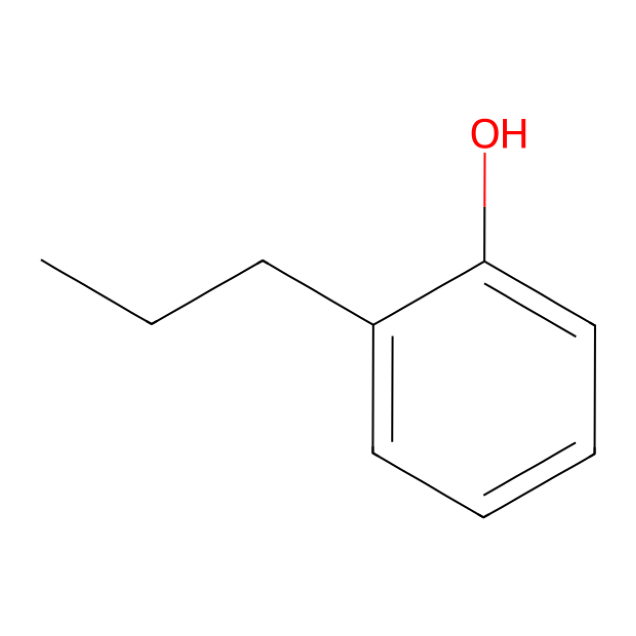

In [ ]:
#@title **Please, provide the necessary input files for the ligand**:

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab or in your Google Drive.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import matplotlib.image as mpimg

import os

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CCCC1=CC=CC=C1O' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
elif Type == "pdb":
  pdb_name = os.path.join(workDir, smiles_or_filename)
  mol= [m for m in pybel.readfile(filename=pdb_name, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
else:
  mol_name = os.path.join(workDir, smiles_or_filename)
  mol = Chem.MolFromMolFile(mol_name)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))

print("Smiles: " + str(Smiles))
smi = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir,str(Smiles) + '.png'))
img = mpimg.imread(os.path.join(workDir,str(Smiles) + '.png'))
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase.optimize import LBFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from openbabel import pybel
from torchani.units import HARTREE_TO_KCALMOL
from xtb.ase.calculator import XTB

#@title **Ligand geometry optimization**:

#@markdown Geometry optimization for the ligand 3D structure, using ANI-1x, ANI-1ccx, ANI-2x or GFN2-xTB as the optimizing engine.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

model_name = "GFN2-xTB" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x", "GFN2-xTB"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  calculator = XTB(method="GFN2-xTB")
  print("Method = GFN2-xTB")


def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "ligand.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)

print("Begin Geometry Optimization ")
opt = LBFGS(atoms)
opt.run(fmax=opt_tol)
# print()
write((os.path.join(workDir, "ligand_min.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "ligand_min.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "ligand_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "ligand_min.pdb")))

ligand_mol=os.path.join(workDir, "ligand_min.mol")
os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")

#TorchANI Energies
# mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand_min.mol")), removeHs=False)
# coordinates, species = mol2arr([mol_deg], device)
# energy = model((species, coordinates)).energies
# derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
# force = -derivative
# print('Energy:', energy.item() * HARTREE_TO_KCALMOL)
print(atoms.get_potential_energy())
# print('Force:', force.squeeze())

Method = GFN2-xTB
Begin Geometry Optimization 
       Step     Time          Energy          fmax
LBFGS:    0 18:56:48     -801.401854        0.711900
LBFGS:    1 18:56:48     -801.422109        0.395101
LBFGS:    2 18:56:48     -801.432879        0.246659
LBFGS:    3 18:56:48     -801.441258        0.177799
LBFGS:    4 18:56:48     -801.444000        0.137463
LBFGS:    5 18:56:48     -801.446353        0.103647
LBFGS:    6 18:56:48     -801.447892        0.107157
LBFGS:    7 18:56:48     -801.449360        0.080978
LBFGS:    8 18:56:49     -801.450251        0.072182
LBFGS:    9 18:56:49     -801.450925        0.061319
LBFGS:   10 18:56:49     -801.451599        0.075953
LBFGS:   11 18:56:49     -801.452332        0.064952
LBFGS:   12 18:56:49     -801.452926        0.054135
LBFGS:   13 18:56:49     -801.453349        0.045391
LBFGS:   14 18:56:49     -801.453745        0.057290
LBFGS:   15 18:56:49     -801.454257        0.069093
LBFGS:   16 18:56:49     -801.454827        0.056663
L

In [ ]:
#@title **Ligand Visualization**:
#@markdown Now the ligand has been optimized, it would be recomended to visualize and check the ligand.

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(os.path.join(workDir, "ligand_min.mol"),'r').read(),format='pdbqt')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Parameters for the docking calculation:**

#@markdown Explicit random seed:
seed = "0" #@param {type:"string"}

scoring = "vina" #@param ["vina", "vinardo"]


#@markdown **Advanced options** `--search_mode` is the recommended setting of `--exhaustiveness` and `--max_step`, with three combinations called `fast`, `balance`, and `detail`.

#@markdown - `fast` mode: `--exhaustiveness 128` & `--max_step 20`
#@markdown - `balance` mode: `--exhaustiveness 384` & `--max_step 40`
#@markdown - `detail` mode: `--exhaustiveness 512` & `--max_step 40`

#@markdown The larger `--exhaustiveness` and `--max_step`, the higher the computational complexity, the higher the accuracy, but the larger the computational cost.

search_mode = "balance" #@param ["fast", "balance", "detail"]
exhaustiveness = 384 #@param {type:"slider", min:8, max:512, step:8}
max_step = 40 #@param {type:"slider", min:0, max:40, step:5}

#@markdown Maximum number of binding modes to generate:
num_modes = 10 #@param {type:"slider", min:1, max:10, step:1}

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

unidock = "./unidock --receptor " + str(receptor_pdbqt) + " --gpu_batch " + str(ligand) + " --search_mode " + str(search_mode) + " --scoring " + str(scoring) + " --center_x " + str(centerX) + " --center_y " + str(centerY) + " --center_z " + str(centerZ) + " --size_x " + str(sizeX) + " --size_y " + str(sizeY) + " --size_z " + str(sizeZ) + " --num_modes " + str(num_modes) + " --dir " + str(workDir) + " --seed " + str(seed) + " --max_step " + str(max_step) + " --exhaustiveness " + str(exhaustiveness)

original_stdout = sys.stdout # Save a reference to the original standard output
with open('unidock.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(unidock)
    sys.stdout = original_stdout # Reset the standard output to its original value
print(unidock)
!chmod 700 unidock.sh 2>&1 1>/dev/null
!bash unidock.sh

ligand_out=os.path.join(workDir, "ligand_out.pdbqt")
ligand_out_sdf=os.path.join(workDir, "ligand_out.sdf")
os.system("obabel -i pdbqt " + str(ligand_out) + " -o sdf -O " + str(ligand_out_sdf) + " -xh")


import gzip
v = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
v.addModel(open(res_box).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(ligand_out_sdf,'rt').read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

./unidock --receptor /content/3HTB/receptor.pdbqt --gpu_batch /content/3HTB/ligand.pdbqt --search_mode balance --scoring vina --center_x 20.066999912261963 --center_y -25.295000076293945 --center_z -2.7880001068115234 --size_x 20.577999259948733 --size_y 21.730000640869136 --size_z 23.650000717163085 --num_modes 10 --dir /content/3HTB --seed 0 --max_step 40 --exhaustiveness 384
Uni-Dock v1.1.0

If you used Uni-Dock in your work, please cite:               
 
Yu, Y., Cai, C., Wang, J., Bo, Z., Zhu, Z., & Zheng, H. (2023). 
Uni-Dock: GPU-Accelerated Docking Enables Ultralarge Virtual Screening. 
Journal of Chemical Theory and Computation.                    
https://doi.org/10.1021/acs.jctc.2c01145                       

Tang, S., Chen, R., Lin, M., Lin, Q., Zhu, Y., Ding, J., ... & Wu, J. (2022). 
Accelerating autodock vina with gpus. Molecules, 27(9), 3041. 
DOI 10.3390/molecules27093041                                 

J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  
A

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Check New Poses Generated for a Given Target with PoseBusters**

#@markdown **PoseBusters** is a Python package designed to perform a series of standard quality checks using the well-established cheminformatics toolkit RDKit. The PoseBusters test suite validates the chemical and geometric consistency of ligands, including their stereochemistry, as well as the physical plausibility of intra- and intermolecular interactions such as the planarity of aromatic rings, bond lengths, and protein-ligand clashes.

#@markdown Here, we are using the dock mode. This is applicable for de novo generated molecules for a given receptor or for ligands that have been docked into a non-cognate receptor.

#@markdown **For more detailed information, please refer to the following publication:** https://doi.org/10.1039/D3SC04185A

from posebusters import PoseBusters
import pandas as pd

# Run PoseBusters
buster = PoseBusters(config="dock")
df = buster.bust([ligand_out_sdf], None, receptor)

# Reset index to remove multi-index (if present)
# df = df.reset_index()
df.reset_index(drop=True)
# Drop unnecessary columns ('file' and 'molecule') if they exist
columns_to_drop = ['file', 'molecule']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Insert 'pose' column at the first position
df.insert(loc=0, column='pose', value=range(1, len(df) + 1))

# Save the DataFrame to a CSV file (without 'file' and 'molecule' columns)
csv_file_path = os.path.join(workDir, 'posebusters_results.csv')
df.to_csv(csv_file_path, index=False)

# Check for False values in any column (excluding 'pose')
failed_poses = df[df.iloc[:, 1:].eq(False).any(axis=1)]

if failed_poses.empty:
    print("All poses successfully passed the validation.")
else:
    print("The following poses failed:")
    print(*failed_poses['pose'].tolist(), sep='\n') # Print values without index

print(f"DataFrame saved as {csv_file_path}")
df

All poses successfully passed the validation.
DataFrame saved as /content/3HTB/posebusters_results.csv


pose  mol_pred_loaded  \
file                         molecule position                          
/content/3HTB/ligand_out.sdf =        0            1             True   
                                      1            2             True   
                                      2            3             True   
                                      3            4             True   
                                      4            5             True   
                                      5            6             True   
                                      6            7             True   
                                      7            8             True   
                                      8            9             True   
                                      9           10             True   

                                                mol_cond_loaded  sanitization  \
file                         molecule position                                  
/content/3HTB/ligand_out.sdf =        0                    True          True   
                                      1                    True          True   
                                      2                    True          True   
                                      3                    True          True   
                                      4                    True          True   
                                      5                    True          True   
                                      6                    True          True   
                                      7                    True          True   
                                      8                    True          True   
                                      9                    True          True   

                                                inchi_convertible  \
file                         molecule position                      
/content/3HTB/ligand_out.sdf =        0                      True   
                                      1                      True   
                                      2                      True   
                                      3                      True   
                                      4                      True   
                                      5                      True   
                                      6                      True   
                                      7                      True   
                                      8                      True   
                                      9                      True   

                                                all_atoms_connected  \
file                         molecule position                        
/content/3HTB/ligand_out.sdf =        0                        True   
                                      1                        True   
                                      2                        True   
                                      3                        True   
                                      4                        True   
                                      5                        True   
                                      6                        True   
                                      7                        True   
                                      8                        True   
                                      9                        True   

                                                bond_lengths  bond_angles  \
file                         molecule position                              
/content/3HTB/ligand_out.sdf =        0                 True         True   
                                      1                 True         True   
                                      2                 True         True   
                                      3                 True         True   
                                      4               

# **Discriminating High from Low Energy Conformers in Docked Poses Molecules**

Accurate and efficient prediction of high energy ligand conformations is crucial in structure-based drug discovery. It helps in the exclusion of unrealistic structures during docking-based virtual screening, ensuring that only realistic and biologically relevant conformers are considered.

The GFN2-xTB method has demonstrated superior performance and appears to be the most suitable approach for use as an internal energy filter within our drug discovery workflow. For more detailed information about the methods and comparisons between them, please refer to: [Comparison of Methods](https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cphc.202400992)


![](https://raw.githubusercontent.com/pablo-arantes/Cloud-Bind/main/diff_energy.jpg)

Machine learning and semiempirical quantum mechanical potentials were assessed for their ability to distinguish high from low energy conformations of druglike molecules. **The GFN2-xTB tight binding density functional method produced the best overall performance.** Figure adapted from *Kong et al.*


---

In [ ]:
#@title **High from Low Energy Conformers Analysis:**
#@markdown Calculate the energy difference between the optimized structure and the docked pose. If the energy barrier is too high **(>8 kcal/mol)**, the pose is unlikely to be a realistic binder.

from rdkit import Chem
import os
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase.optimize import LBFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from openbabel import pybel
from torchani.units import HARTREE_TO_KCALMOL
from xtb.ase.calculator import XTB
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal

model_name = "GFN2-xTB" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x", "GFN2-xTB"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.01 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  calculator = XTB(method="GFN2-xTB")
  print("Method = GFN2-xTB")

workDir_conf = os.path.join(workDir, 'conformer_docking')

workDir_check = os.path.exists(workDir_conf)
if workDir_check == False:
  os.mkdir(workDir_conf)
else:
  pass

results=Chem.SDMolSupplier(ligand_out_sdf,False)

supplier = Chem.SDMolSupplier(ligand_out_sdf, removeHs=False)  # Replace 'ligand_out.sdf' with your SDF file path

for i, mol in enumerate(supplier):
    if mol is not None:  # Check if molecule is valid
        # Save as SDF
        Chem.MolToMolFile(mol, os.path.join(workDir_conf, f'molecule_{i + 1}.sdf'))

        # Save as PDB
        Chem.MolToPDBFile(mol, os.path.join(workDir_conf, f'molecule_{i + 1}.pdb'))

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

potential_energy_pre =[]
potential_energy_opt = []
difference_energy = []
for i, molec in enumerate(results):
    output_file = os.path.join(workDir_conf, f"molecule_{i}.mol")
    Chem.MolToMolFile(molec, output_file)
    mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir_conf, output_file)), removeHs=False)
    mol = io.read(os.path.join(workDir_conf, output_file))
    coordinates, species = mol2arr([mol_deg], device)
    tensor1 = coordinates.detach().numpy()
    atoms_pre = Atoms(mol, positions=tensor1[0])
    atoms_pre.set_calculator(calculator)
    pot_energy = atoms_pre.get_potential_energy() * 23.0605914748611
    potential_energy_pre.append(pot_energy)
    atoms_pre.get_kinetic_energy
    #Geometry Optimization
    atoms_opt = Atoms(mol, positions=tensor1[0])
    atoms_opt.center(vacuum=3.0)
    atoms_opt.set_calculator(calculator)
    print("Begin Geometry Optimization ")
    opt_opt = LBFGS(atoms_opt)
    opt_opt.run(fmax=opt_tol)
    pot_energy_opt = atoms_opt.get_potential_energy() * 23.0605914748611
    potential_energy_opt.append(pot_energy_opt)

    write((os.path.join(workDir_conf, f"molecule_{i}_min.xyz")), format="xyz", images=atoms_opt)
    diff_energy = float(pot_energy_opt - pot_energy)
    difference_energy.append(diff_energy)
    print(f"Pose {i} = {pot_energy}")
    print(f"Optimized Pose {i} = {pot_energy_opt}")

print("RESULTS:")
for i, mol in enumerate(difference_energy):
    if abs(float(mol)) > 8:
        print(f"Difference Energy for Pose {i+1} = {mol:>8.3f} kcal/mol #WARNING: Use with caution!")
    else:
        print(f"Difference Energy for Pose {i+1} = {mol:>8.3f} kcal/mol")

Method = GFN2-xTB
Begin Geometry Optimization 
       Step     Time          Energy          fmax
LBFGS:    0 18:57:21     -801.325632        0.689736
LBFGS:    1 18:57:21     -801.336697        0.401441
LBFGS:    2 18:57:21     -801.351037        0.447453
LBFGS:    3 18:57:21     -801.366963        0.359681
LBFGS:    4 18:57:21     -801.378165        0.276059
LBFGS:    5 18:57:21     -801.388584        0.245936
LBFGS:    6 18:57:21     -801.396765        0.221528
LBFGS:    7 18:57:21     -801.402900        0.173250
LBFGS:    8 18:57:21     -801.407081        0.145286
LBFGS:    9 18:57:21     -801.411065        0.151840
LBFGS:   10 18:57:21     -801.414839        0.133199
LBFGS:   11 18:57:21     -801.417867        0.140518
LBFGS:   12 18:57:21     -801.420122        0.110943
LBFGS:   13 18:57:22     -801.422156        0.103665
LBFGS:   14 18:57:22     -801.424252        0.113863
LBFGS:   15 18:57:22     -801.426121        0.093511
LBFGS:   16 18:57:22     -801.427460        0.124152
L

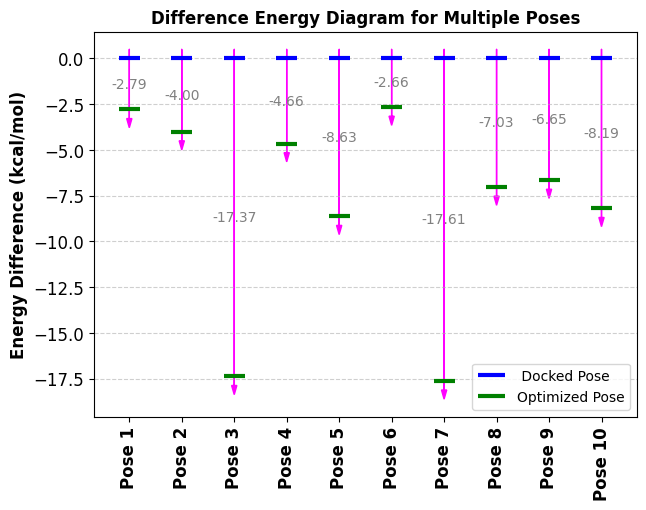

In [ ]:
#@title **Plot the Difference Energy Diagram**:
Output_name = 'Energy_diagram' #@param {type:"string"}

import matplotlib.pyplot as plt
import numpy as np

# Number of systems
num_systems = len(difference_energy)

# X-axis positions
x_positions = np.arange(num_systems)

# Create plot
plt.figure(figsize=(7, 5))

# Plot each system's transition
for i in range(num_systems):
    plt.hlines(0, i - 0.2, i + 0.2, colors='b', linewidth=3, label=" Docked Pose" if i == 0 else "")  # Optimized Pose
    plt.hlines(difference_energy[i], i - 0.2, i + 0.2, colors='g', linewidth=3, label="Optimized Pose" if i == 0 else "")  # Pose

    plt.arrow(i, 0.5, 0, difference_energy[i] - 1, head_width=0.1, head_length=0.5, fc='magenta', ec='magenta')  # Transition arrow

    # Annotate energy difference
    plt.text(i, difference_energy[i] / 2, f"{difference_energy[i]:.2f}",
             ha='center', va='center', fontsize=10, color='gray')

# Labels
plt.xticks(x_positions, [f"Pose {i+1}" for i in range(num_systems)],rotation=90,fontsize=12,fontweight='bold')
plt.yticks(fontsize = 12)

plt.ylabel("Energy Difference (kcal/mol)", fontsize=12,fontweight='bold')
plt.title("Difference Energy Diagram for Multiple Poses", fontsize=12,fontweight='bold')
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Add legend
plt.legend()
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Calculate the Root Mean Square Deviation (RSMD) for Docked x Optimized Pose**:


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolAlign import GetBestRMS
from rdkit.Geometry import Point3D
from ase.io import read
import os
import pandas as pd

rmsd_values = []

for i, molec in enumerate(results):
    output_file = os.path.join(workDir_conf, f"molecule_{i}.mol")
    Chem.MolToMolFile(molec, output_file)

    # Load the initial pose (RDKit molecule)
    mol_pre = Chem.MolFromMolFile(output_file, removeHs=False)

    # Read optimized XYZ file using ASE
    opt_xyz_file = os.path.join(workDir_conf, f"molecule_{i}_min.xyz")
    atoms_opt = read(opt_xyz_file)  # ASE Atoms object with positions

    # Convert ASE Atoms back to RDKit Mol using initial connectivity
    mol_opt = Chem.Mol(mol_pre)  # Copy initial molecule
    conf = Chem.Conformer(mol_opt.GetNumAtoms())

    # Assign optimized atomic positions
    for j, pos in enumerate(atoms_opt.get_positions()):
        conf.SetAtomPosition(j, Point3D(float(pos[0]), float(pos[1]), float(pos[2])))

    mol_opt.RemoveAllConformers()  # Ensure no previous conformers exist
    mol_opt.AddConformer(conf, assignId=True)  # Assign the new conformer

    # Save the optimized structure as a MOL file
    optimized_mol_file = os.path.join(workDir_conf, f"molecule_{i}_opt.mol")
    Chem.MolToMolFile(mol_opt, optimized_mol_file)

    if mol_pre is not None and mol_opt is not None:
        # Compute RMSD
        rmsd = GetBestRMS(mol_pre, mol_opt)
        rmsd_values.append(rmsd)
        print(f"RMSD for Pose {i+1}: {rmsd:.3f}")
    else:
        print(f"Error loading molecules for RMSD calculation, skipping Molecule {i}")

# Save RMSD values
rmsd_df = pd.DataFrame({'Molecule': list(range(1, len(rmsd_values) + 1)), 'RMSD': rmsd_values})
rmsd_df.to_csv(os.path.join(workDir, "rmsd_results.csv"), index=False)

RMSD for Pose 1: 0.174
RMSD for Pose 2: 0.387
RMSD for Pose 3: 1.072
RMSD for Pose 4: 0.341
RMSD for Pose 5: 0.574
RMSD for Pose 6: 0.342
RMSD for Pose 7: 0.528
RMSD for Pose 8: 0.415
RMSD for Pose 9: 0.327
RMSD for Pose 10: 0.403


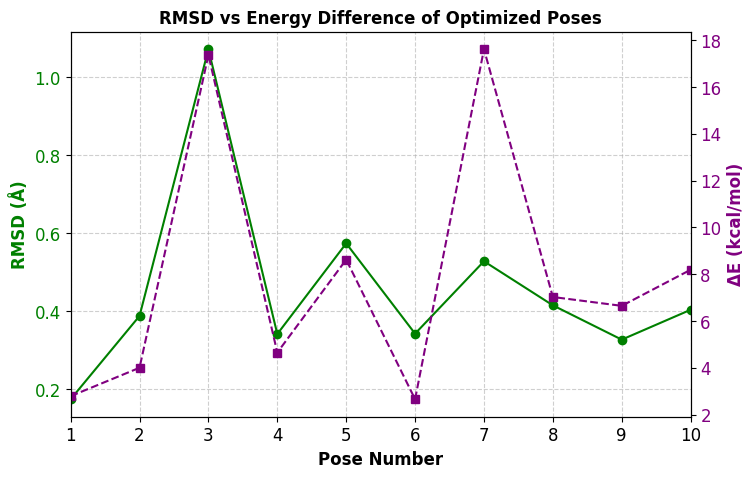

In [ ]:
#@title **Plot the RMSD and Energy Difference together on the same graph**:
#@markdown	•	RMSD (Å) in green (solid line, circles) on the left Y-axis.

#@markdown  •	Energy Difference (ΔE in kcal/mol) in Purple (dashed line, squares) on the right Y-axis.

#@markdown	•	Both plotted against Pose Number on the X-axis.

#@markdown This visualization helps identify whether higher RMSD values correlate with larger energy differences.

Output_name = 'RMSD_Energy_Difference' #@param {type:"string"}

import matplotlib.pyplot as plt

# Convert energy difference to absolute values for better visualization
abs_energy_diff = [abs(e) for e in difference_energy]

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 5))
plt.xlim(1, len(rmsd_values))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Plot RMSD (left y-axis)
ax1.plot(range(1, len(rmsd_values) + 1), rmsd_values, marker='o', linestyle='-', color='green', markersize=6, label="RMSD")
ax1.set_xlabel("Pose Number", fontsize=12,fontweight='bold')
ax1.set_ylabel("RMSD (Å)", fontsize=12, fontweight='bold', color='green')
ax1.tick_params(axis='y', labelcolor='green')


# Create secondary y-axis for energy differences
ax2 = ax1.twinx()
ax2.plot(range(1, len(difference_energy) + 1), abs_energy_diff, marker='s', linestyle='--', color='purple', markersize=6, label="ΔE (kcal/mol)")
ax2.set_ylabel("ΔE (kcal/mol)", color='purple', fontsize=12,fontweight='bold')
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# Title and Grid
plt.title("RMSD vs Energy Difference of Optimized Poses",  fontsize=12,fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Save the plot
plot_file = os.path.join(workDir, "rmsd_energy_plot.png")
plt.savefig(plot_file, dpi=300)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

Reference residues: Gray | Uni-Dock Pose: Green


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

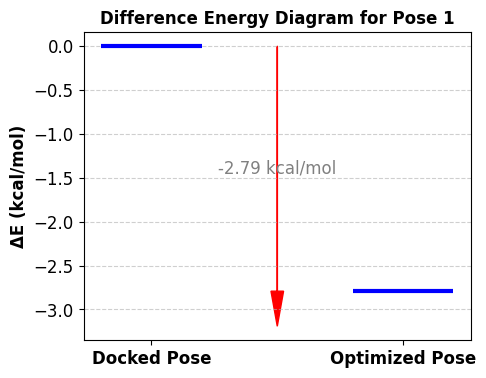

In [ ]:
#@title **Best pose selection:**

mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


import matplotlib.pyplot as plt

# X-axis positions
x_positions = [1, 2]
energy_levels = [0, difference_energy[int(mode_number)-1]]  # Normalize to show only the difference

# Create the plot
plt.figure(figsize=(5, 4))

# Plot energy levels as horizontal lines
plt.hlines(energy_levels, xmin=[0.8, 1.8], xmax=[1.2, 2.2], colors='b', linewidth=3)

# Add a small arrow to indicate the transition
plt.arrow(1.5, energy_levels[0], 0, energy_levels[1] - energy_levels[0],
        head_width=0.05, head_length=0.4, fc='r', ec='r')

# Labels
plt.xticks(x_positions, ["Docked Pose", "Optimized Pose"],fontsize=12,fontweight='bold')
plt.yticks(fontsize = 12)
plt.ylabel("ΔE (kcal/mol)", fontsize=12,fontweight='bold')
plt.title(f"Difference Energy Diagram for Pose {int(mode_number)}", fontsize=12,fontweight='bold')

# Annotate only the energy difference
plt.text(1.5, energy_levels[1] / 2, f"{difference_energy[int(mode_number)-1]:.2f} kcal/mol",
            ha='center', va='center', fontsize=12, color='gray')

plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.savefig(os.path.join(workDir, f"Transition_state_pose_{int(mode_number)}.png"), dpi=600, bbox_inches='tight')

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

view.addModel(open(receptor,'r').read(),'pdb')
Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'},'stick':{'radius':.1}})
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.2,'color':'white'})


view.addModel(open(res_box,'r').read(),'pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'grayCarbon','radius':0.2}})


results=Chem.SDMolSupplier(ligand_out_sdf,False)
p=Chem.MolToMolBlock(results[(int(mode_number)-1)],False)
p2=Chem.MolToMolFile(results[(int(mode_number)-1)],(os.path.join(workDir, str(int(mode_number)) + "_pose.sdf")))

print('Reference residues: Gray | Uni-Dock Pose: Green')
view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

In [ ]:
#@title **Binding Affinity Prediction:**


#@markdown We will calculate the binding affinity prediction using a novel featurization technique known as **AEV-PLIG** (Atomic Environment Vectors and Protein–Ligand Interaction Graphs). This method combines atomic environment vectors (AEVs) with protein–ligand interaction graphs (PLIGs) to capture complex interactions between protein and ligand atoms. AEV-PLIG leverages an expressive attentional Graph Neural Network (GNN) architecture that dynamically learns the relative importance of neighboring environments, enabling it to model intricate and nuanced interactions.

#@markdown The resulting method consistently demonstrates comparable or superior performance across a wide range of benchmarks when compared to other machine learning-based methods. Training with augmented data significantly enhances prediction correlation and ranking for congeneric series—commonly encountered in drug discovery—and offers an effective route to improve accuracy. Additionally, AEV-PLIG is orders of magnitude faster than Free Energy Perturbation (FEP) simulations, requires minimal per-system preparation, and provides absolute binding affinities rather than relative free energy differences.

#@markdown **For more detailed information, please refer to the following publication:** https://doi.org/10.1038/s42004-025-01428-y

import csv
from pathlib import Path

# Data from previous cell
unique_id = str(int(mode_number))
sdf_file = (os.path.join(workDir, str(int(mode_number)) + "_pose.sdf"))
pdb_file = receptor

# Create the CSV file and write data
csv_file_path = Path('/content/input.csv')

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['unique_id', 'sdf_file', 'pdb_file'])

    # Write the data row
    writer.writerow([unique_id, sdf_file, pdb_file])

subprocess.run(f"python /content/AEV-PLIG/process_and_predict.py --dataset_csv=/content/input.csv --data_name=pose_{mode_number} --trained_model_name=model_GATv2Net_ligsim90_fep_benchmark", shell=True)

# Specify the path to your CSV file
csv_file_path = Path(f'/content/AEV-PLIG/output/predictions/pose_{mode_number}_predictions.csv')

# Initialize variables for the specific pose (pose 1, graph_id 0)
graph_id = 0

with open(csv_file_path, mode='r', newline='') as file:
    # Create a CSV reader object
    csv_reader = csv.DictReader(file)

    # Iterate over each row in the CSV file
    for row in csv_reader:
          # Extract the predicted value for the specific pose
          preds_values = float(row[f'preds'])
          r = 8.3145  # J/mol/K
          t = 297  # K
          k = 10**-preds_values
          dg_j = r * t * np.log(k)  # Natural log
          dg_kcal = dg_j / 4184
            # Print the formatted output
          print(f"The predicted binding affinity for pose {mode_number} is {dg_kcal:.4f} kcal/mol")

The predicted binding affinity for pose 1 is -5.7791 kcal/mol


In [ ]:
%%bash
#@title **Calculating the protein-small molecule conformational ensembles with PLACER**

#@markdown Protein-Ligand Atomistic Conformational Ensemble Resolver (PLACER) is a rapid and stochastic denoising network, which enables generation of ensembles of solutions to model conformational heterogeneity.

#@markdown **For more detailed information:** https://github.com/baker-laboratory/PLACER
source activate placer_env
python
import sys, os

Google_Drive_Path = '/content/3HTB' #@param {type:"string"}
workDir = Google_Drive_Path
workDir_conf = os.path.join(workDir, 'conformer_docking')

#@markdown Best pose:
mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

#@markdown Number of samples to generate, 50-100 is a good number in most cases.
n_samples = 50 #@param {type:"slider", min:10, max:200, step:10}

receptor_file = os.path.join(workDir, "receptor.pdb")
molecule_file = os.path.join(workDir_conf, f"molecule_{mode_number}.pdb")
output_file = os.path.join(workDir, f"pose_{mode_number}.pdb")

with open(output_file, 'w') as outfile:
    with open(receptor_file, 'r') as infile1:
        lines = infile1.readlines()  # Read all lines of receptor.pdb
        outfile.writelines(lines[:-1])  # Write all lines except the last
    with open(molecule_file, 'r') as infile2:
        next(infile2)  # Skip the first line of molecule_1.pdb
        outfile.write(infile2.read())  # Write the rest of molecule_1.pdb

receptor = os.path.join(workDir, f"pose_{mode_number}.pdb")
ligand = os.path.join(workDir_conf, f"molecule_{mode_number}.sdf")

import warnings
warnings.filterwarnings("ignore")
import json
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(f"/content/PLACER/")
import PLACER

# Initializing PLACER model with default checkpoint
placer = PLACER.PLACER()

print("""
###############################################
# Predicting a designed for the selected mode #
###############################################
""")
import numpy
pdbfile = receptor
pdbstr = open(pdbfile, "r").read()

ODIR = os.path.join(workDir, "outputs_PLACER")

inp_dict = {"ligand_reference": {"UNL": ligand},
            "name": os.path.basename(pdbfile).replace(".pdb", ""),
            "pdb": pdbstr}

pl_inp = PLACER.PLACERinput()
pl_inp.create_from_dict(inp_dict)
outputs_denovo2 = placer.run(pl_inp, int(n_samples))

# Ranking outputs by prmsd
outputs_denovo2 = PLACER.utils.rank_outputs(outputs_denovo2, "prmsd")

# Dumping output models to PDB
os.makedirs(ODIR, exist_ok=True)
print(f"Writing outputs to {ODIR}")
PLACER.protocol.dump_output(outputs_denovo2, f"{ODIR}/{pl_inp.name()}")

df = pd.DataFrame.from_dict({k: [outputs_denovo2[n][k] for n in outputs_denovo2] for k in outputs_denovo2[0].keys() if k not in ["item", "model", "center"]})

# Generating plots of RMSD vs confidence metrics
plt.figure(figsize=(16, 4))
plt.suptitle(pl_inp.name(), weight="bold", size=14)
for i,k in enumerate(["prmsd", "plddt", "plddt_pde"]):
    plt.subplot(1, 3, i+1)
    plt.scatter(x=df["rmsd"], y=df[k])
    plt.xlabel("lig rmsd", weight="bold", size=14)
    plt.ylabel(k, weight="bold", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
plt.tight_layout()
plt.savefig(f"{ODIR}/results_PLACER_mode_{mode_number}.png", dpi=600, bbox_inches='tight')

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
# device:  cuda:0
Using checkpoint: /content/PLACER/weights/PLACER_model_1.pt
# variables:  5071802

###############################################
# Predicting a designed for the selected mode #
###############################################

Reading ligand UNL reference definition from file: /content/3HTB/conformer_docking/molecule_1.sdf
Keeping these ligands fixed during prediction IF they are in the crop: [].
--> 0 pose_1 {ID:type/atoms/bonds} : {A:polypeptide(L)/2635/2655; :nonpoly/22/22}
model    1 :  fape= 1.47578  lddt= 0.96096  rmsd= 0.78244  kabsch= 0.44499  prmsd= 1.78713  plddt= 0.99000  plddt_pde= 0.79736  | time= 7.11s  mem= 3.13gb 
model    2 :  fape= 1.50689  lddt= 0.96261  rmsd= 0.36228  kabsch= 0.09743  prmsd= 0.96711  plddt= 0.99000  plddt_pde= 0.95783  | time= 3.99s 

DGL backend not selected or invalid.  Assuming PyTorch for now.


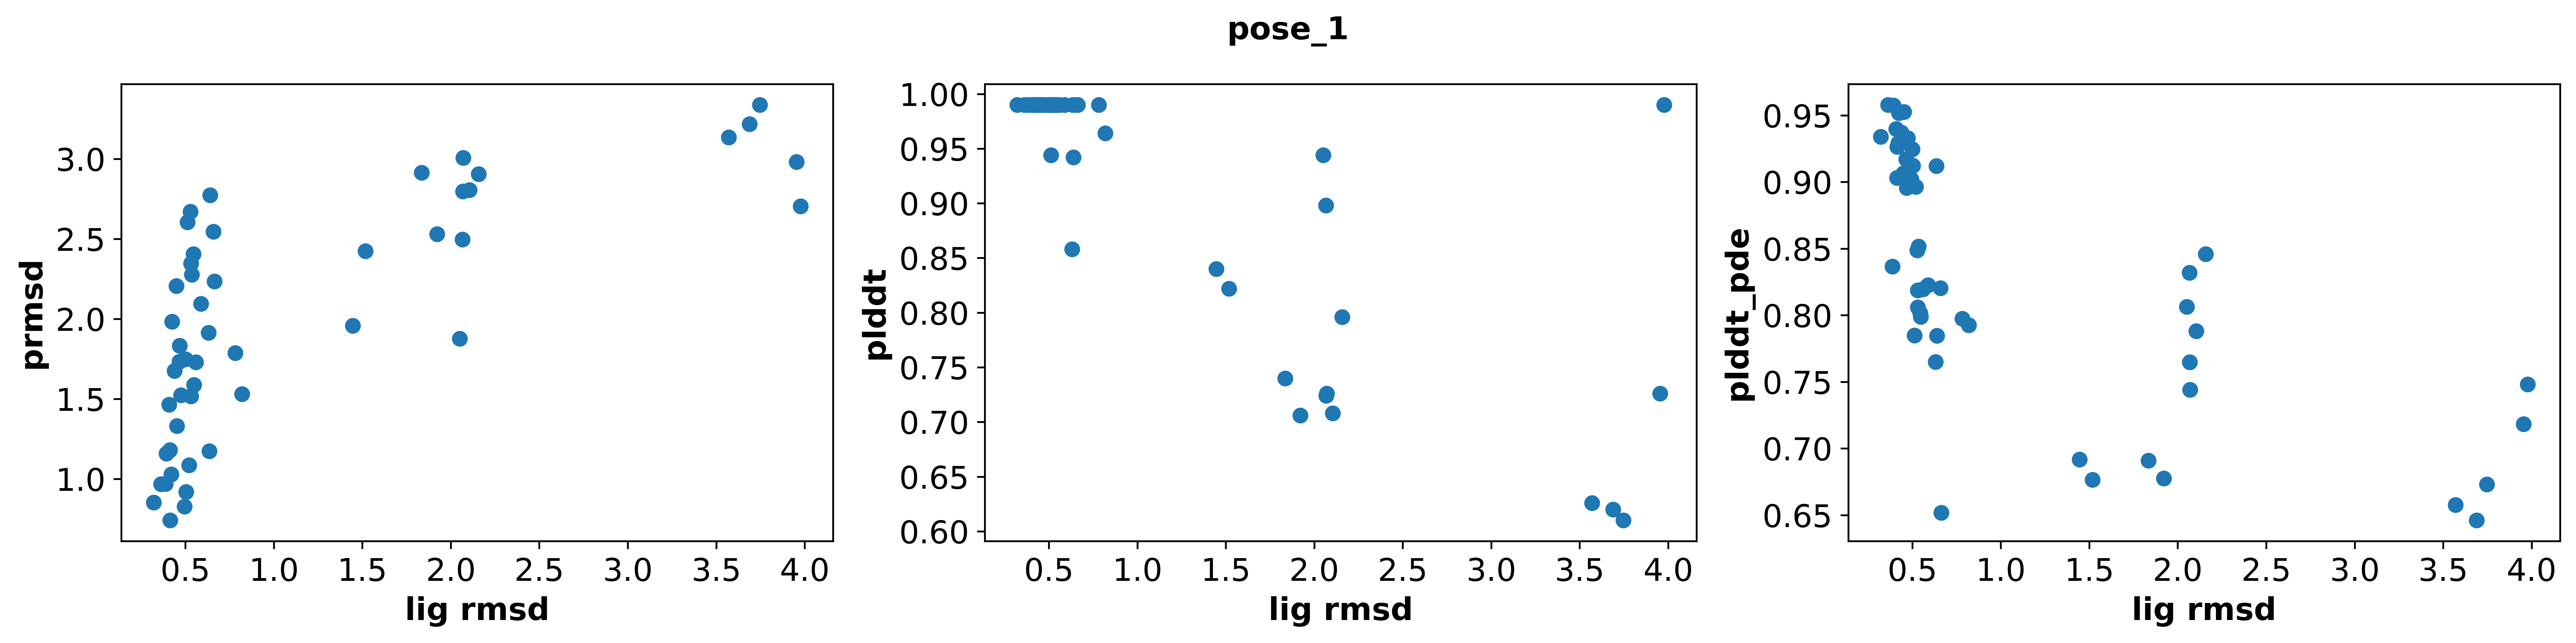

In [ ]:
#@title **Check the PLACER results**

#@markdown **Best pose:**

mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


from IPython.display import Image

Image(filename=os.path.join(workDir, f"outputs_PLACER/results_PLACER_mode_{mode_number}.png"))


In [ ]:
#@title **Filter unphysical samples (e.g., steric clashes) from the PLACER ensemble**

#@markdown This cell applies structural filters to ligands in an ensemble to remove unphysical conformations while retaining the full system for valid frames.

#@markdown The ligand is evaluated on each frame using the following criteria:

#@markdown - ✅ **Steric Clashes** – Checks if atoms are too close together.
#@markdown - ✅ **Bond Lengths** – Identifies abnormally long or short bonds.
#@markdown - ✅ **Bond Angles** – Flags angles outside a reasonable range.

#@markdown Frames where the ligand passes all filters are saved into a new trajectory file, preserving the entire molecular system.

import os
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
from scipy.spatial.distance import pdist

# Load trajectory
pdb_path = os.path.join(workDir, f"outputs_PLACER/pose_{mode_number}_model.pdb")
u = mda.Universe(pdb_path, pdb_path)

# Align protein structure
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

# Save aligned topology
pdb_file = u.select_atoms("all")
pdb_file.write("topology.pdb")

# Reload topology and trajectory
u = mda.Universe("topology.pdb", pdb_path)
all_atoms = u.select_atoms("all")  # Select all atoms

### **Fix: Ensure Ligand is Selected per Frame** ###
def get_ligand_selection(universe):
    ligand = universe.select_atoms("resname UNL")
    if len(ligand) == 0:
        raise ValueError("Ligand selection is empty. Check if 'resname UNL' is correct.")
    ligand.guess_bonds()
    return ligand

### FILTERING FUNCTIONS ###

def has_steric_clashes(ligand, min_distance=1.0):
    """Check if ligand atoms are too close together (steric clashes)."""
    if len(ligand) < 2:
        return False  # Single-atom ligands cannot have clashes
    distances = pdist(ligand.positions)
    return any(dist < min_distance for dist in distances)

def has_unusual_bond_lengths(ligand, min_bond=0.9, max_bond=1.8):
    """Check for unrealistic bond lengths in the ligand."""
    if len(ligand.bonds) == 0:
        return False  # No bonds to check
    for bond in ligand.bonds.to_indices():
        if bond[0] >= len(ligand) or bond[1] >= len(ligand):
            continue  # Skip invalid indices
        dist = np.linalg.norm(ligand.positions[bond[0]] - ligand.positions[bond[1]])
        if dist < min_bond or dist > max_bond:
            return True  # Unrealistic bond length found
    return False

def has_unusual_angles(ligand, min_angle=80, max_angle=180):
    """Check for unrealistic bond angles using vector-based calculation."""
    if not hasattr(ligand, "angles") or len(ligand.angles) == 0:
        return False  # No angles to check
    positions = ligand.positions
    for angle in ligand.angles.to_indices():
        if max(angle) >= len(positions):  # Prevent index errors
            continue
        a, b, c = positions[angle[0]], positions[angle[1]], positions[angle[2]]

        # Compute vectors
        v1 = a - b
        v2 = c - b

        # Compute cosine of the angle using the dot product
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        theta = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))  # Convert to degrees

        if theta < min_angle or theta > max_angle:
            return True  # Unrealistic angle found
    return False

### APPLY FILTERS TO LIGAND ###

def ligand_is_realistic(ligand):
    """Check all filtering criteria for the ligand."""
    return not (
        has_steric_clashes(ligand) or
        has_unusual_bond_lengths(ligand) or
        has_unusual_angles(ligand)
    )

### SAVE FILTERED TRAJECTORY ###

new_traj = os.path.join(workDir, "PLACER_filter.pdb")
with mda.Writer(new_traj, all_atoms.n_atoms) as W:
    for ts in u.trajectory:
        ligand_sel = get_ligand_selection(u)  # Update ligand selection per frame
        if ligand_is_realistic(ligand_sel):  # Apply filter only to ligand
            W.write(all_atoms)  # Save full system if ligand passes

print(f"Filtered trajectory saved to: {new_traj}")

Filtered trajectory saved to: /content/3HTB/PLACER_filter.pdb


In [ ]:
#@title **Check the PLACER ensemble**
#@markdown Examine the ensemble created by PLACER, along with the ligand’s Root Mean Square Deviation (RMSD) and Radius of Gyration (Rg).

#@markdown **Best pose:**

mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
from logmd import LogMD
from tqdm import tqdm
import numpy as np
import time

# Load the trajectory
u = mda.Universe(os.path.join(workDir, f"outputs_PLACER/pose_{mode_number}_model.pdb"), os.path.join(workDir, f"outputs_PLACER/pose_{mode_number}_model.pdb"))

# Align to the first frame (can also align to an average structure)
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

pdb_file = u.select_atoms("all")
pdb_file.write("topology.pdb")
u = mda.Universe("topology.pdb", os.path.join(workDir, "PLACER_filter.pdb"))

# Store the initial positions for RMSD calculation
initial_position = u.select_atoms("resname UNL").positions

def fun(atoms):
    # Convert atoms to AtomGroup
    atom_group = u.select_atoms("resname UNL")
    # Calculate norm
    # norm = np.linalg.norm(atoms.positions - initial_position)

    # Calculate RMSD (no alignment)
    rmsd = np.sqrt(np.mean(np.sum((u.select_atoms("resname UNL").positions - initial_position) ** 2, axis=1)))

    # Calculate Radius of Gyration (Rg)
    com = atom_group.center_of_mass()
    rg = np.sqrt(np.mean(np.sum((u.select_atoms("resname UNL").positions - com) ** 2, axis=1)))

    # Data dictionary to log
    data_dict = {
        # 'norm': f"{norm:.2f} [A]",
        'rmsd': f"{rmsd:.2f} [A]",
        'rg': f"{rg:.2f} [A]",
    }

    return data_dict

# Run the analysis
a = LogMD.mdanalysis(u, fun, display_notebook=False)
LogMD.display_notebook(a, width=1200, height=800)

Processing frames: 100%|██████████| 48/48 [00:00<00:00, 210.46it/s]
Uploading: 100%|██████████| 749k/749k [00:00<00:00, 2.53MB/s]


[logmd] Url=]8;id=212174;https://rcsb.ai/314ec340c7\https]8;;\]8;id=855110;https://rcsb.ai/314ec340c7\://rcsb.ai/314ec340c7]8;;\ ✅

The average binding affinity is -5.8919 ± 0.1236 kcal/mol


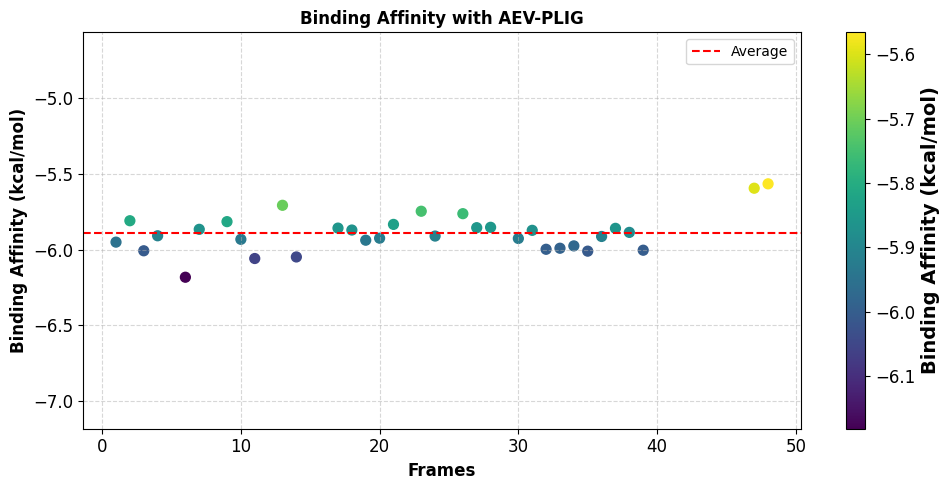

In [ ]:
#@title **Calculate the binding affinity prediction over the ensemble using a AEV-PLIG**

mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

Add_hydrogens = True #@param {type:"boolean"}

Skip = 1 #@param {type:"slider", min:1, max:100, step:1}

import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import numpy as np
from pdbfixer import PDBFixer
from pymol import cmd
import glob
import csv
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

if os.path.exists(os.path.join(workDir, 'PDBs_affinity/')):
  cmd.delete("all")
  global execution_count
  execution_count += 1
else:
  execution_count = 0

if os.path.exists('/content/input_ensemble.csv'):
  os.remove('/content/input_ensemble.csv')
else:
  pass

pdb_dir = os.path.join(workDir,'PDBs_affinity/')
pdb_dir_check = os.path.exists(pdb_dir)
if pdb_dir_check == False:
  os.mkdir(pdb_dir)
else:
  pass

# Load the trajectory
u = mda.Universe(os.path.join(workDir, f"outputs_PLACER/pose_{mode_number}_model.pdb"), os.path.join(workDir, f"outputs_PLACER/pose_{mode_number}_model.pdb"))

# Align to the first frame (can also align to an average structure)
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

pdb_file = u.select_atoms("all")
pdb_file.write(os.path.join(workDir,"topology.pdb"))

u1 = mda.Universe(os.path.join(workDir,"topology.pdb"), os.path.join(workDir, "PLACER_filter.pdb"))

csv_file_path = Path('/content/input_ensemble.csv')

# Open the CSV file *once* before the loop in 'write' mode to add the header
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['unique_id', 'sdf_file', 'pdb_file'])  # Write header once

protein_atoms = u1.select_atoms("protein")
ligand_atoms = u1.select_atoms("resname UNL")
i = 0
for ts in u1.trajectory[0:len(u1.trajectory):int(Skip)]:
  i += 1
  if i > -1:
    with mda.Writer(os.path.join(pdb_dir,f'receptor_frame{i}.pdb'), protein_atoms.n_atoms) as W:
      W.write(protein_atoms)
    with mda.Writer(os.path.join(pdb_dir,f'ligand_frame{i}.pdb'), ligand_atoms.n_atoms) as W:
      W.write(ligand_atoms)

    name_pymol = f'ligand_frame{i}'
    pdb_file = os.path.join(pdb_dir,f'ligand_frame{i}.pdb')  # Replace with your PDB file path
    sdf_file = os.path.join(pdb_dir,f'ligand_frame{i}.sdf')  # Replace with your desired SDF file path

    if Add_hydrogens:
      # Add hydrogens protein
      fixer = PDBFixer(filename=os.path.join(pdb_dir,f'receptor_frame{i}.pdb'))
      fixer.removeHeterogens()
      fixer.findMissingResidues()
      fixer.findMissingAtoms()
      fixer.addMissingAtoms()
      fixer.addMissingHydrogens(pH=7.4) # add hydrogens with pdbfixer
      PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(pdb_dir,f'receptor_frame{i}_H.pdb'), 'w'))
      receptor_pdb = os.path.join(pdb_dir,f'receptor_frame{i}_H.pdb')

      # Add hydrogens ligand
      cmd.load(pdb_file, name_pymol)
      cmd.h_add(name_pymol)  # Add hydrogens to the loaded molecule
      cmd.save(sdf_file, name_pymol, format="sdf")
    else:
      receptor_pdb = os.path.join(pdb_dir,f'receptor_frame{i}.pdb')
      cmd.load(pdb_file, name_pymol)
      cmd.save(sdf_file, name_pymol, format="sdf")

    unique_id = int(i)

    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([unique_id, sdf_file, receptor_pdb])  # Append data
  else:
        print(f"Warning: Could not create molecule from {pdb_file}. Skipping SDF writing.")

subprocess.run(f"python /content/AEV-PLIG/process_and_predict.py --dataset_csv=/content/input_ensemble.csv --data_name=ensemble{execution_count} --trained_model_name=model_GATv2Net_ligsim90_fep_benchmark", shell=True)

# Specify the path to your CSV file
csv_file_path = Path(f'/content/AEV-PLIG/output/predictions/ensemble{execution_count}_predictions.csv')

# Initialize variables for the specific pose (pose 1, graph_id 0)
graph_id = 0

with open(csv_file_path, mode='r', newline='') as file:
    # Create a CSV reader object
    csv_reader = csv.DictReader(file)
    j = 0
    # Iterate over each row in the CSV file
    dg_kcal_list = []
    for row in csv_reader:
          # Extract the predicted value for the specific pose
          preds_values = float(row[f'preds'])
          r = 8.3145  # J/mol/K
          t = 297  # K
          k = 10**-preds_values
          dg_j = r * t * np.log(k) # Natural log
          dg_kcal = dg_j / 4184
          dg_kcal_list.append(dg_kcal)
          # print(f"The predicted binding affinity is {dg_kcal:.4f} kcal/mol")
    dg_avearage = np.mean(dg_kcal_list)
    dg_std = np.std(dg_kcal_list)
    print(f"The average binding affinity is {dg_avearage:.4f} ± {dg_std:.4f} kcal/mol")
    df = pd.read_csv(f'/content/AEV-PLIG/output/predictions/ensemble{execution_count}_predictions.csv')
    frames = df['unique_id']
    new_df = pd.DataFrame({'Frames': frames, 'Binding Affinity (kcal/mol)': dg_kcal_list})
    new_df.to_csv(os.path.join(workDir,'Affinity_AEV-PLIG_PLACER.csv'), index=False)

# Plot the binding affinity
plt.figure(figsize=(10, 5))
sc = plt.scatter(frames, dg_kcal_list, c=dg_kcal_list, cmap='viridis', s=50)
cbar = plt.colorbar(sc)
cbar.set_label('Binding Affinity (kcal/mol)', fontsize=14, fontweight='bold')  # Colorbar label size
cbar.ax.yaxis.set_tick_params(labelsize=12)  # Increase colorbar tick label size
plt.axhline(np.mean(dg_kcal_list), color='red', linestyle='--', label='Average')
min = np.min(dg_kcal_list)-1
max = np.max(dg_kcal_list)+1
plt.ylim(min, max)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('Frames',fontsize=12,fontweight='bold')
plt.ylabel('Binding Affinity (kcal/mol)',fontsize=12,fontweight='bold')
plt.title('Binding Affinity with AEV-PLIG',fontsize=12,fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(workDir, "Affinity_AEV-PLIG_PLACER.png"), dpi=600, bbox_inches='tight')

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import subprocess
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem, Draw, PandasTools
import seaborn as sns
import os
#@title **Evaluate the poses over the ensemble with the pre-trained GNINA models**
#@markdown Pose (CNNscore) and binding affinity (Affinity Score and CNNaffinity) predictions with GNINA models.

# @markdown Minimize ligands already positioned in a binding site:
minimization = "No" #@param ["Yes","No"]
Skip = 1 #@param {type:"slider", min:1, max:100, step:1}
pdb_dir = os.path.join(workDir,'PDBs/')
pdb_dir_check = os.path.exists(pdb_dir)
if pdb_dir_check == False:
  os.mkdir(pdb_dir)
else:
  pass

u1 = mda.Universe("topology.pdb", os.path.join(workDir, "PLACER_filter.pdb"))

if minimization == 'Yes':
  minimize = "--minimize"
else:
  minimize = "--score_only"

affinity = []
CNNscore = []
CNNaffinity = []
protein_atoms = u1.select_atoms("protein")
ligand_atoms = u1.select_atoms("resname UNL")
i = 0
for ts in u1.trajectory[0:len(u1.trajectory):int(Skip)]:
  if i > -1:
    with mda.Writer(os.path.join(pdb_dir,'protein.pdb'), protein_atoms.n_atoms) as W:
      W.write(protein_atoms)
    with mda.Writer(os.path.join(pdb_dir,'ligand.pdb'), ligand_atoms.n_atoms) as W:
      W.write(ligand_atoms)
  gnina_score = f"./gnina -r {pdb_dir}protein.pdb -l {pdb_dir}ligand.pdb {minimize} -o score_gnina.sdf"
  subprocess.run(gnina_score, shell=True)
  print(f"Running frame {i}")

  result=Chem.SDMolSupplier("score_gnina.sdf",True)
  affinity.append(float(result[0].GetProp('minimizedAffinity')))
  CNNscore.append(float(result[0].GetProp('CNNscore')))
  CNNaffinity.append(float(result[0].GetProp('CNNaffinity')))
  i = i + 1

raw_data=pd.DataFrame(affinity)
raw_data.to_csv(os.path.join(workDir,f"GNINA_affinity.csv"))
raw_data=pd.DataFrame(CNNscore)
raw_data.to_csv(os.path.join(workDir,f"GNINA_CNNscore.csv"))
raw_data=pd.DataFrame(CNNaffinity)
raw_data.to_csv(os.path.join(workDir,f"GNINA_CNNaffinity.csv"))

[19:07:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 0


[19:07:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 1


[19:07:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 2


[19:07:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 3


[19:07:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 4


[19:07:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 5


[19:07:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 6


[19:07:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 7


[19:07:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 8


[19:07:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:07:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 9


[19:08:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 10


[19:08:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 11


[19:08:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 12


[19:08:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 13


[19:08:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 14


[19:08:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 15


[19:08:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 16


[19:08:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 17


[19:08:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 18


[19:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 19


[19:08:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 20


[19:08:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 21


[19:08:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 22


[19:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 23


[19:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 24


[19:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 25


[19:09:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 26


[19:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 27


[19:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 28


[19:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 29


[19:09:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 30


[19:09:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 31


[19:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 32


[19:09:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 33


[19:09:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 34


[19:09:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 35


[19:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 36


[19:09:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 37


[19:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 38


[19:10:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 39


[19:10:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 40


[19:10:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 41


[19:10:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 42


[19:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 43


[19:10:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 44


[19:10:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 45


[19:10:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 46


[19:10:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:10:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Running frame 47


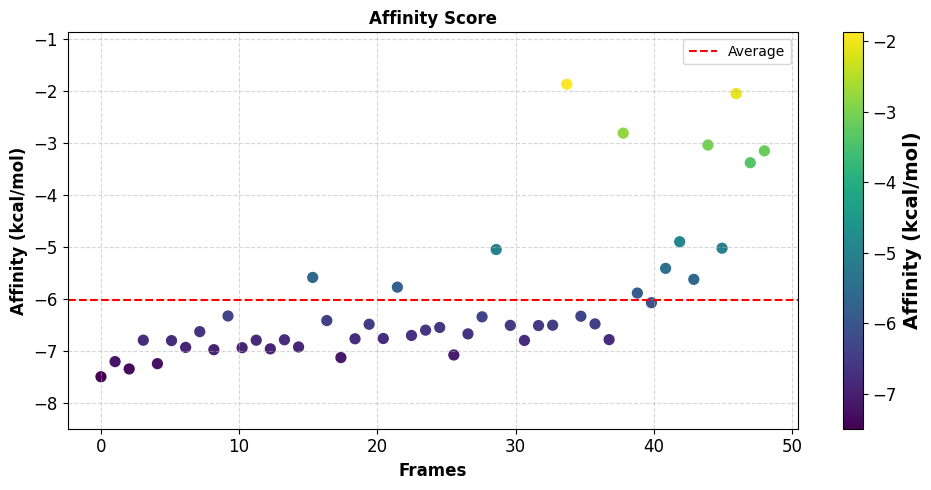

<Figure size 640x480 with 0 Axes>

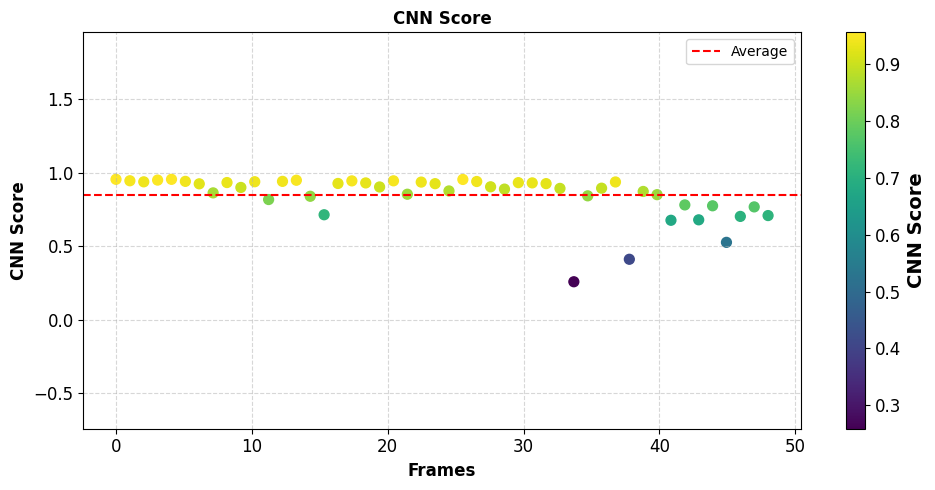

<Figure size 640x480 with 0 Axes>

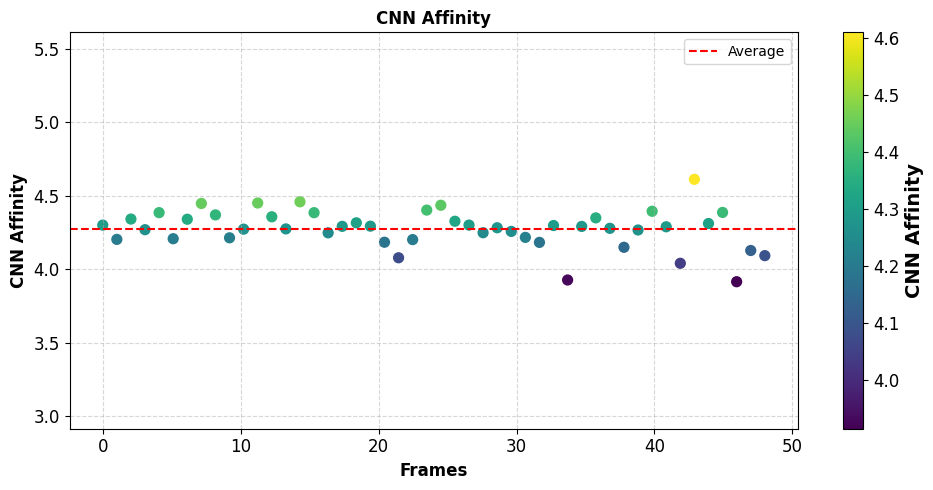

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title **Plot the Affinity Score, CNNscore and CNNaffinity, calculated with GNINA models**
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

time_sequence = np.linspace(0,int(len(u1.trajectory)/int(Skip)),int(len(u1.trajectory)/int(Skip)))

plt.figure(figsize=(10, 5))
plt.title('Affinity Score',fontsize=12,fontweight='bold')
sc = plt.scatter(time_sequence, affinity, c=affinity, cmap='viridis', s=50)
cbar = plt.colorbar(sc)
cbar.set_label('Affinity (kcal/mol)', fontsize=14, fontweight='bold')  # Colorbar label size
cbar.ax.yaxis.set_tick_params(labelsize=12)  # Increase colorbar tick label size
plt.axhline(np.mean(affinity), color='red', linestyle='--', label='Average')
min = np.min(affinity)-1
max = np.max(affinity)+1
plt.ylim(min, max)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('Frames',fontsize=12,fontweight='bold')
plt.ylabel('Affinity (kcal/mol)',fontsize=12,fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(workDir, "Affinity_Score_PLACER.png"), dpi=600, bbox_inches='tight')
raw_data=pd.DataFrame(affinity)
raw_data.to_csv(os.path.join(workDir, "Affinity_Score_PLACER.csv"))


plt.figure(figsize=(10, 5))
plt.title('CNN Score', fontsize=12, fontweight='bold')
sc = plt.scatter(time_sequence, CNNscore, c=CNNscore, cmap='viridis', s=50)
cbar = plt.colorbar(sc)
cbar.set_label('CNN Score', fontsize=14, fontweight='bold')  # Colorbar label size
cbar.ax.yaxis.set_tick_params(labelsize=12)  # Increase colorbar tick label size
plt.axhline(np.mean(CNNscore), color='red', linestyle='--', label='Average')
min = np.min(CNNscore) - 1
max = np.max(CNNscore) + 1
plt.ylim(min, max)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frames', fontsize=12, fontweight='bold')
plt.ylabel('CNN Score', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(workDir, "CNNscore_PLACER.png"), dpi=600, bbox_inches='tight')
raw_data = pd.DataFrame(CNNscore)
raw_data.to_csv(os.path.join(workDir, "CNNscore_PLACER.csv"))


plt.figure(figsize=(10, 5))
plt.title('CNN Affinity', fontsize=12, fontweight='bold')
sc = plt.scatter(time_sequence, CNNaffinity, c=CNNaffinity, cmap='viridis', s=50)
cbar = plt.colorbar(sc)
cbar.set_label('CNN Affinity', fontsize=14, fontweight='bold')  # Colorbar label size
cbar.ax.yaxis.set_tick_params(labelsize=12)  # Increase colorbar tick label size
plt.axhline(np.mean(CNNaffinity), color='red', linestyle='--', label='Average')
min = np.min(CNNaffinity) - 1
max = np.max(CNNaffinity) + 1
plt.ylim(min, max)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frames', fontsize=12, fontweight='bold')
plt.ylabel('CNN Affinity', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(workDir, "CNNaffinity_PLACER.png"), dpi=600, bbox_inches='tight')
raw_data = pd.DataFrame(CNNaffinity)
raw_data.to_csv(os.path.join(workDir, "CNNaffinity_PLACER.csv"))

In [ ]:
#@title **Best pose selection from PLACER ensemble:**

Frame = "2" #@param {type:"string"}

if int(Frame) > (len(u1.trajectory)/int(Skip)-int(1)):
  print("You didn't save enough frames in your trajectory. Please, run the previous cell again with a lower skip.")
  exit()
else:
  pass

protein_ligand = u1.select_atoms("resname UNL")
with mda.Writer(os.path.join(workDir,f'ligand_' + str(Frame) + '.pdb'), protein_ligand.n_atoms) as W:
  for ts in u1.trajectory[int(Frame):(int(Frame)+1):1]:
    W.write(protein_ligand)


view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

view.addModel(open(receptor,'r').read(),'pdb')
Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'},'stick':{'radius':.1}})
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.2,'color':'white'})

print ('Affinity: {}'.format(affinity[(int(Frame)-1)]))
print ('CNN Score: {}'.format(CNNscore[(int(Frame)-1)]))
print ('CNN Affinity: {}'.format(CNNaffinity[(int(Frame)-1)]))


view.addModel(open(os.path.join(workDir,f'ligand_' + str(Frame) + '.pdb'),'r').read(),'pdb')
HP = ['UNL']
view.addStyle({'and':[{'resn':HP}]},
              {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
view.setViewStyle({'style':'outline','color':'black','width':0.1})


view.zoomTo()
view.show()

Affinity: -7.20802
CNN Score: 0.9458462596
CNN Affinity: 4.201854229


3Dmol.js failed to load for some reason. Please check your browser console for error messages.